In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets, ops
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==========================================
# CONFIGURATION
# ==========================================
SOURCE_PATH = r'colored_images'  # <--- UPDATE THIS!
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 5

print(f"🚀 Device: {DEVICE} | Classes: {NUM_CLASSES}")

# ==========================================
# DATA LOADING (5-CLASS MAPPING)
# ==========================================
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class FiveClassEyePACS(datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target_idx = super().__getitem__(index)
        class_name = self.classes[target_idx]
        
        # FORCE MEDICAL ORDER (0 -> 4)
        # Default ImageFolder sorts alphabetically. We must fix this.
        label_map = {
            'No_DR': 0,
            'Mild': 1,
            'Moderate': 2,
            'Severe': 3,
            'Proliferate_DR': 4
        }
        
        label = label_map.get(class_name, 0) # Default to 0 if fails
        return sample, label

try:
    full_dataset = FiveClassEyePACS(root=SOURCE_PATH, transform=data_transforms)
    
    # SPLIT DATA
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"✅ Data Loaded.")
    print(f"   Classes detected: {full_dataset.classes}")
    print(f"   Mapped to: 0=No_DR, 1=Mild, 2=Moderate, 3=Severe, 4=Proliferate")
    
except Exception as e:
    print(f"❌ Error: {e}")

🚀 Device: cuda | Classes: 5
✅ Data Loaded.
   Classes detected: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
   Mapped to: 0=No_DR, 1=Mild, 2=Moderate, 3=Severe, 4=Proliferate


In [6]:
def train_and_evaluate(name, model, train_loader, val_loader, test_loader, epochs=5):
    print(f"\n🚀 Training {name}...")
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # TRAIN
        model.train()
        correct = 0; total = 0; running_loss = 0.0
        
        # Enumerate gives us the batch index 'i'
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # PRINT PROGRESS EVERY 10 BATCHES
            if i % 10 == 0:
                print(f"   [Epoch {epoch+1}] Batch {i}/{len(train_loader)} processed...")
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # VALIDATE
        model.eval()
        val_correct = 0; val_total = 0; val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
        val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss/len(val_loader))
        history['val_acc'].append(val_acc)
        
        print(f"✅ Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # --- EVALUATION PLOTS ---
    print(f"\n📊 Final Test Evaluation for {name}...")
    model.eval()
    y_true = []; y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # PLOT GRAPHS
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='red')
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title(f'{name} Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc', color='blue')
    plt.plot(history['val_acc'], label='Val Acc', color='green')
    plt.title(f'{name} Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    class_names = ['No_DR', 'Mild', 'Mod', 'Sev', 'Prolif']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=class_names))
    return model

In [7]:
# 1. Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(), nn.Linear(128, 5) # <--- 5 CLASSES
        )
    def forward(self, x): return self.classifier(self.features(x))

# 2. ResNet18
def get_resnet18():
    model = models.resnet18(weights='DEFAULT')
    model.fc = nn.Linear(512, 5) # <--- 5 CLASSES
    return model

# 3. Deformable ResNet
class DeformableConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DeformableConvLayer, self).__init__()
        self.stride = stride
        self.padding = padding
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.offset_conv = nn.Conv2d(in_channels, 2 * kernel_size * kernel_size, kernel_size, stride, padding)
    def forward(self, x):
        offset = self.offset_conv(x)
        return ops.deform_conv2d(x, offset, self.conv.weight, self.conv.bias, stride=self.stride, padding=self.padding)

def get_deformable_resnet():
    model = models.resnet18(weights='DEFAULT')
    model.layer4[1].conv2 = DeformableConvLayer(512, 512, stride=1)
    model.fc = nn.Linear(512, 5) # <--- 5 CLASSES
    return model


🚀 Training SimpleCNN...
   [Epoch 1] Batch 0/879 processed...
   [Epoch 1] Batch 10/879 processed...
   [Epoch 1] Batch 20/879 processed...
   [Epoch 1] Batch 30/879 processed...
   [Epoch 1] Batch 40/879 processed...
   [Epoch 1] Batch 50/879 processed...
   [Epoch 1] Batch 60/879 processed...
   [Epoch 1] Batch 70/879 processed...
   [Epoch 1] Batch 80/879 processed...
   [Epoch 1] Batch 90/879 processed...
   [Epoch 1] Batch 100/879 processed...
   [Epoch 1] Batch 110/879 processed...
   [Epoch 1] Batch 120/879 processed...
   [Epoch 1] Batch 130/879 processed...
   [Epoch 1] Batch 140/879 processed...
   [Epoch 1] Batch 150/879 processed...
   [Epoch 1] Batch 160/879 processed...
   [Epoch 1] Batch 170/879 processed...
   [Epoch 1] Batch 180/879 processed...
   [Epoch 1] Batch 190/879 processed...
   [Epoch 1] Batch 200/879 processed...
   [Epoch 1] Batch 210/879 processed...
   [Epoch 1] Batch 220/879 processed...
   [Epoch 1] Batch 230/879 processed...
   [Epoch 1] Batch 240/879

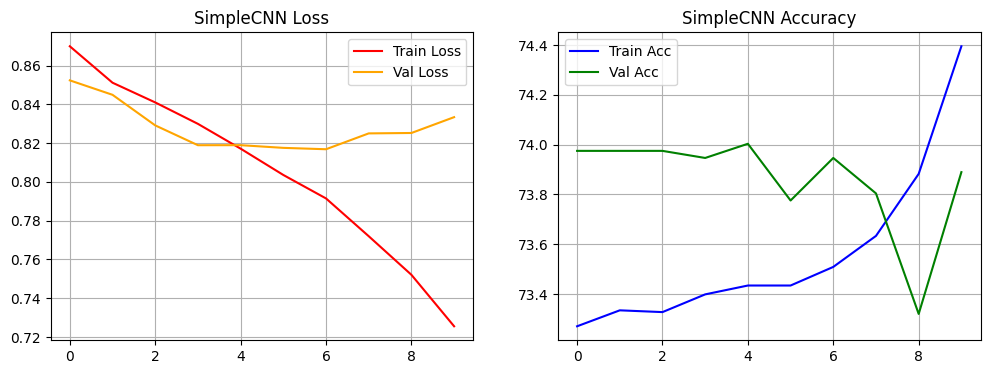

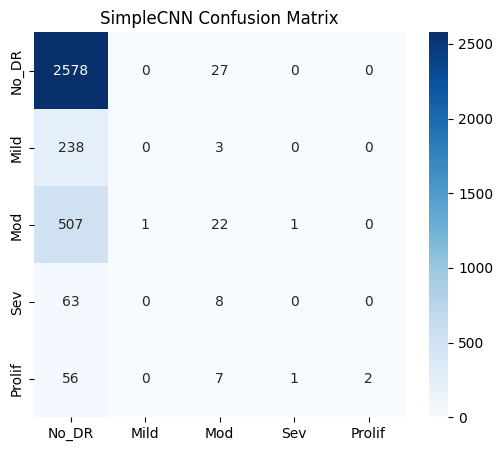

              precision    recall  f1-score   support

       No_DR       0.75      0.99      0.85      2605
        Mild       0.00      0.00      0.00       241
         Mod       0.33      0.04      0.07       531
         Sev       0.00      0.00      0.00        71
      Prolif       1.00      0.03      0.06        66

    accuracy                           0.74      3514
   macro avg       0.42      0.21      0.20      3514
weighted avg       0.62      0.74      0.64      3514



In [8]:
model_cnn = SimpleCNN()
model_cnn = train_and_evaluate("SimpleCNN", model_cnn, train_loader, val_loader, test_loader, EPOCHS)
 


🚀 Training ResNet18...
   [Epoch 1] Batch 0/879 processed...
   [Epoch 1] Batch 10/879 processed...
   [Epoch 1] Batch 20/879 processed...
   [Epoch 1] Batch 30/879 processed...
   [Epoch 1] Batch 40/879 processed...
   [Epoch 1] Batch 50/879 processed...
   [Epoch 1] Batch 60/879 processed...
   [Epoch 1] Batch 70/879 processed...
   [Epoch 1] Batch 80/879 processed...
   [Epoch 1] Batch 90/879 processed...
   [Epoch 1] Batch 100/879 processed...
   [Epoch 1] Batch 110/879 processed...
   [Epoch 1] Batch 120/879 processed...
   [Epoch 1] Batch 130/879 processed...
   [Epoch 1] Batch 140/879 processed...
   [Epoch 1] Batch 150/879 processed...
   [Epoch 1] Batch 160/879 processed...
   [Epoch 1] Batch 170/879 processed...
   [Epoch 1] Batch 180/879 processed...
   [Epoch 1] Batch 190/879 processed...
   [Epoch 1] Batch 200/879 processed...
   [Epoch 1] Batch 210/879 processed...
   [Epoch 1] Batch 220/879 processed...
   [Epoch 1] Batch 230/879 processed...
   [Epoch 1] Batch 240/879 

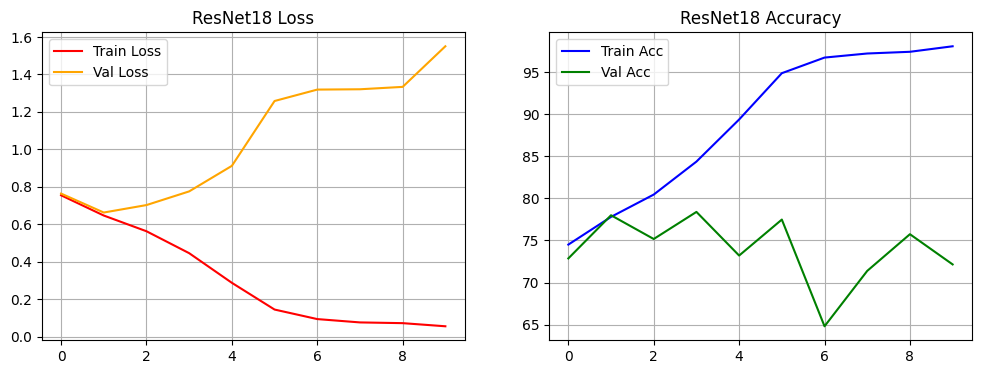

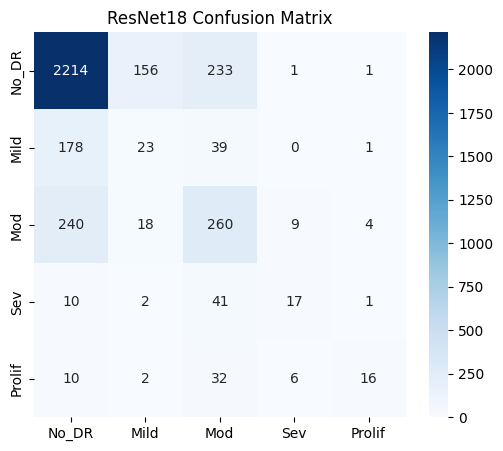

              precision    recall  f1-score   support

       No_DR       0.83      0.85      0.84      2605
        Mild       0.11      0.10      0.10       241
         Mod       0.43      0.49      0.46       531
         Sev       0.52      0.24      0.33        71
      Prolif       0.70      0.24      0.36        66

    accuracy                           0.72      3514
   macro avg       0.52      0.38      0.42      3514
weighted avg       0.72      0.72      0.71      3514



In [9]:
   
    # Train Model B
model_resnet = get_resnet18()
model_resnet = train_and_evaluate("ResNet18", model_resnet, train_loader, val_loader, test_loader, EPOCHS)
    


🚀 Training DeformableResNet...
   [Epoch 1] Batch 0/879 processed...
   [Epoch 1] Batch 10/879 processed...
   [Epoch 1] Batch 20/879 processed...
   [Epoch 1] Batch 30/879 processed...
   [Epoch 1] Batch 40/879 processed...
   [Epoch 1] Batch 50/879 processed...
   [Epoch 1] Batch 60/879 processed...
   [Epoch 1] Batch 70/879 processed...
   [Epoch 1] Batch 80/879 processed...
   [Epoch 1] Batch 90/879 processed...
   [Epoch 1] Batch 100/879 processed...
   [Epoch 1] Batch 110/879 processed...
   [Epoch 1] Batch 120/879 processed...
   [Epoch 1] Batch 130/879 processed...
   [Epoch 1] Batch 140/879 processed...
   [Epoch 1] Batch 150/879 processed...
   [Epoch 1] Batch 160/879 processed...
   [Epoch 1] Batch 170/879 processed...
   [Epoch 1] Batch 180/879 processed...
   [Epoch 1] Batch 190/879 processed...
   [Epoch 1] Batch 200/879 processed...
   [Epoch 1] Batch 210/879 processed...
   [Epoch 1] Batch 220/879 processed...
   [Epoch 1] Batch 230/879 processed...
   [Epoch 1] Batch 

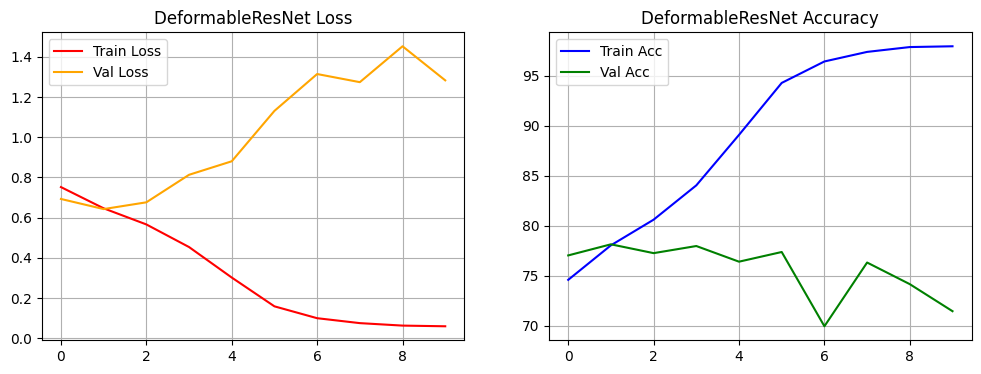

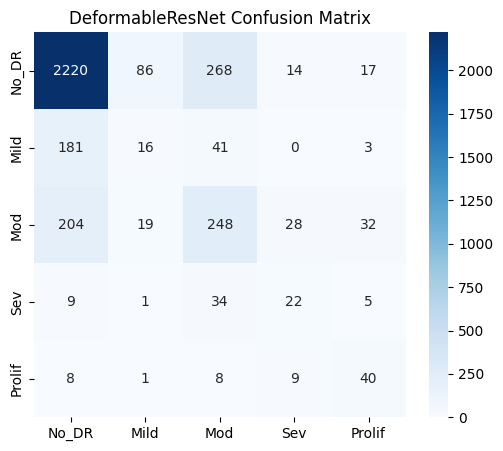

              precision    recall  f1-score   support

       No_DR       0.85      0.85      0.85      2605
        Mild       0.13      0.07      0.09       241
         Mod       0.41      0.47      0.44       531
         Sev       0.30      0.31      0.31        71
      Prolif       0.41      0.61      0.49        66

    accuracy                           0.72      3514
   macro avg       0.42      0.46      0.43      3514
weighted avg       0.71      0.72      0.72      3514



In [10]:

    # Train Model C
model_deform = get_deformable_resnet()
model_deform = train_and_evaluate("DeformableResNet", model_deform, train_loader, val_loader, test_loader, EPOCHS)


🏆 ENSEMBLE EVALUATION (5-Class)...
✅ Ensemble Accuracy: 77.40%


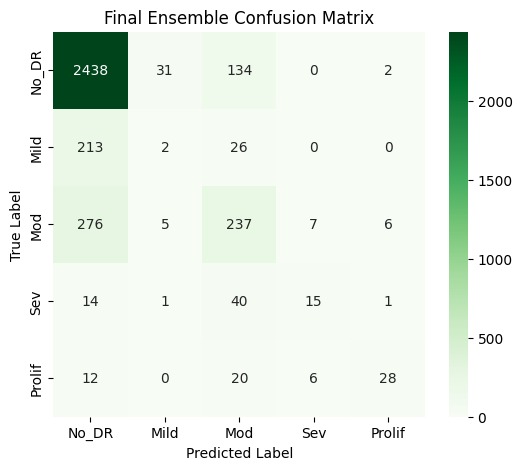

              precision    recall  f1-score   support

       No_DR       0.83      0.94      0.88      2605
        Mild       0.05      0.01      0.01       241
         Mod       0.52      0.45      0.48       531
         Sev       0.54      0.21      0.30        71
      Prolif       0.76      0.42      0.54        66

    accuracy                           0.77      3514
   macro avg       0.54      0.41      0.44      3514
weighted avg       0.72      0.77      0.74      3514



In [12]:
import torch.nn.functional as F  # <--- This fixes the NameError
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🏆 ENSEMBLE EVALUATION (5-Class)...")

# Ensure models are loaded from previous cells
models_dict = {
    "SimpleCNN": model_cnn,
    "ResNet18": model_resnet,
    "Deformable": model_deform
}

y_true = []
# Store probabilities (shape: [N, 5])
probs_simple = []
probs_resnet = []
probs_deform = []

with torch.no_grad():
    for model in models_dict.values(): model.eval()
    
    for images, labels in test_loader:
        images = images.to(DEVICE)
        y_true.extend(labels.cpu().numpy())
        
        # Get probabilities from each model
        # softmax converts raw scores into probabilities (0 to 1)
        p1 = F.softmax(models_dict["SimpleCNN"](images), dim=1)
        probs_simple.extend(p1.cpu().numpy())
        
        p2 = F.softmax(models_dict["ResNet18"](images), dim=1)
        probs_resnet.extend(p2.cpu().numpy())
        
        p3 = F.softmax(models_dict["Deformable"](images), dim=1)
        probs_deform.extend(p3.cpu().numpy())

# Ensemble Voting (Average of probabilities)
# This is "Soft Voting" - often more accurate than hard voting
avg_probs = (np.array(probs_simple) + np.array(probs_resnet) + np.array(probs_deform)) / 3
final_preds = np.argmax(avg_probs, axis=1)

# Metrics
acc = accuracy_score(y_true, final_preds)
print(f"✅ Ensemble Accuracy: {acc*100:.2f}%")

# Plot Confusion Matrix
cm = confusion_matrix(y_true, final_preds)
plt.figure(figsize=(6, 5))
class_names = ['No_DR', 'Mild', 'Mod', 'Sev', 'Prolif']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Final Ensemble Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(classification_report(y_true, final_preds, target_names=class_names))